# **TO GRANT OR NOT TO GRANT: DECIDING ON COMPENSATION BENEFITS - PART 2: VISUAL EXPLORATION**

## 1. Imports, options and ingestion

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
import seaborn as sns
import json

In [2]:
# setting the options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=np.inf)
plt.style.use('seaborn-v0_8-dark')

In [3]:
df_dict = {
    'train': 'df',
    'test': 'df_test'
}

for name, dataframe in df_dict.items():
    # open the json with the dataframe datatypes
    with open(f'../Data/{name}_dtypes_initial_inspection.json', 'r') as f:
        dtypes = json.load(f)

    # save the column data type mappings
    dtype_mapping = {}
    date_cols = []
    for col, dtype in dtypes.items():
        if dtype == 'datetime64[ns]':
            dtype_mapping[col] = 'object'
            date_cols.append(col)
        else:
            dtype_mapping[col] = dtype

    # import the data with specified datatypes
    globals()[dataframe] = pd.read_csv(
        f'../Data/{name}_data_initial_inspection.csv'
        ,sep=','
        ,index_col=0
        ,dtype=dtype_mapping
    )

    # set the date columns datatype
    for date in date_cols:
        globals()[dataframe][date] = pd.to_datetime(globals()[dataframe][date])

# to avoid the 'is not defined' warning
df = df
df_test = df_test

## 2. Visual inspection

We now start the visual inspection of our data</br></br>
<span style="color:red">Note:</span> we exclude from this analysis all columns related with descriptions since the ones with the codes carry the same information

In [4]:
# defining the numeric, date and categorical features
numeric_features = [
    'Age at Injury'
    ,'Average Weekly Wage'
    ,'Birth Year'
    ,'IME-4 Count'
    ,'Number of Dependents'
    ,'Days Difference'
    ,'Log Age at Injury'
    ,'Log Average Weekly Wage'
    ,'Log Birth Year'
    ,'Log IME-4 Count'
    ,'Log Number of Dependents'
]
date_features = [
    'Accident Date'
    , 'Assembly Date'
    , 'C-2 Date'
    , 'C-3 Date'
    , 'First Hearing Date'
]
categorical_features = [
    'Alternative Dispute Resolution'
    ,'Attorney/Representative'
    ,'Carrier Name'
    ,'Carrier Type'
    ,'Claim Injury Type'
    ,'County of Injury'
    ,'COVID-19 Indicator'
    ,'District Name'
    ,'Gender'
    ,'Industry Code'
    ,'Medical Fee Region'
    ,'WCIO Cause of Injury Code'
    ,'WCIO Nature of Injury Code'
    ,'WCIO Part Of Body Code'
    ,'Zip Code'
    ,'Agreement Reached'
    ,'WCB Decision'
    ,'C-2 Missed Timing'
    ,'C-3 Missed Timing'
    ,'C-2 Missing'
    ,'C-3 Missing'
    ,'Has Hearing'
    ,'Has IME-4 Report'
]

all_features = numeric_features + date_features + categorical_features

## 3. Histograms

### 3.1. Numeric Features

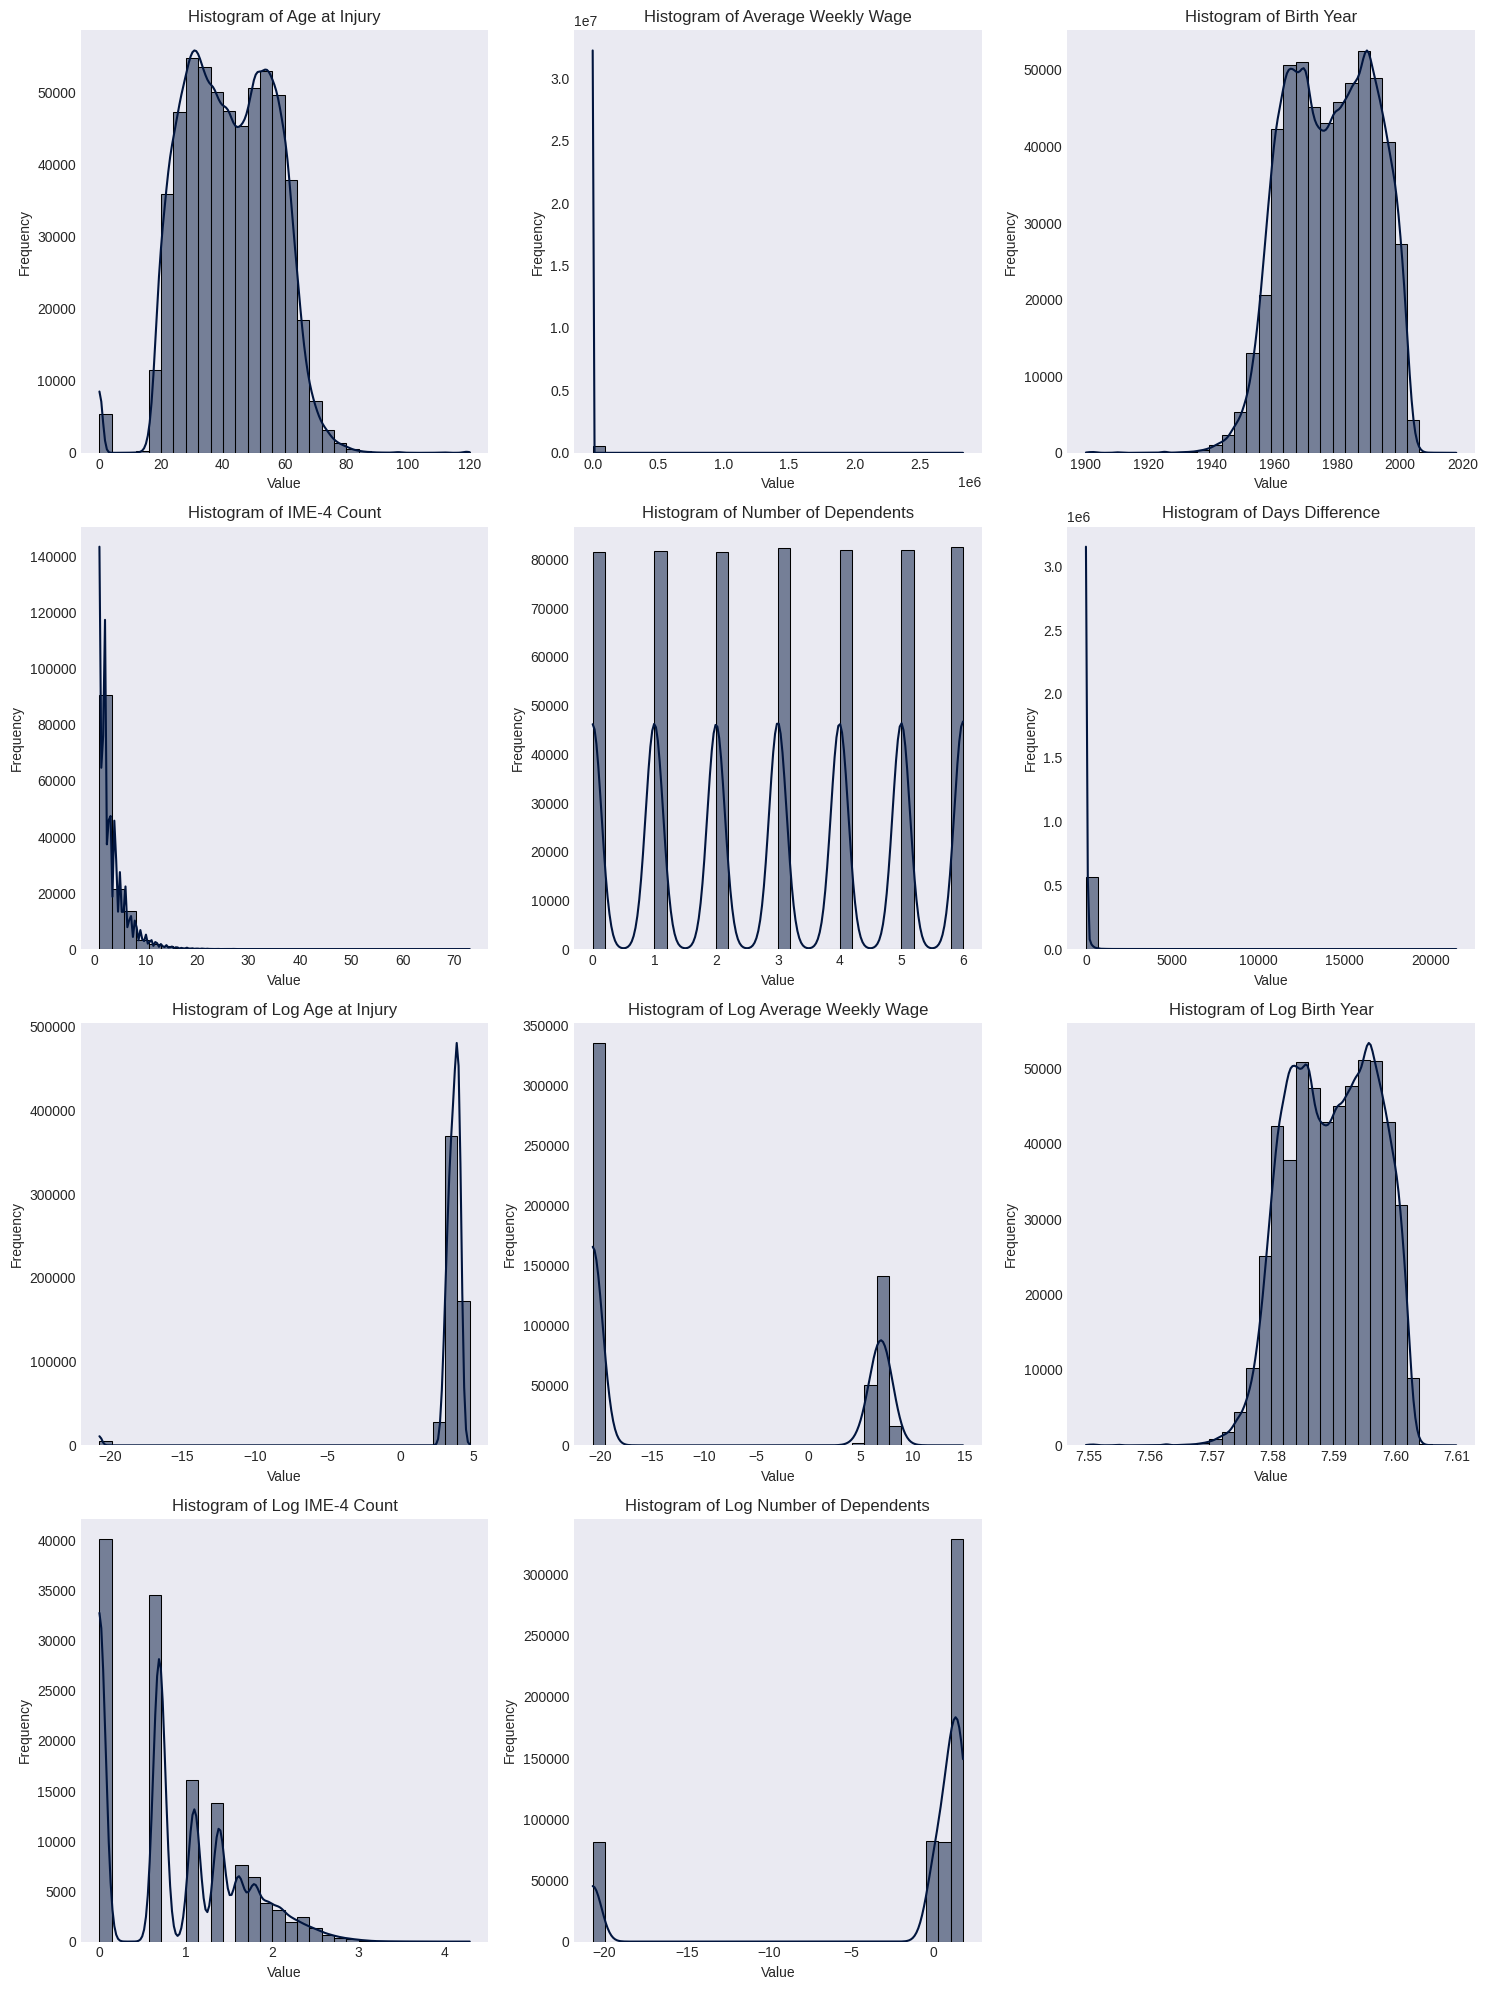

In [5]:
num_features = len(numeric_features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns

# create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# iterate over each feature to plot histograms
for ax, feature in zip(axes, numeric_features):
    sns.histplot(df[feature].dropna(), bins=30, color='#01153e', kde=True, ax=ax) 
    ax.set_title(f'Histogram of {feature}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# hide any empty subplots
for i in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[i])

# adjust layout to prevent overlap
plt.tight_layout()

plt.show()

It seems we have a lot of extreme values in 'Average Weekly Wage'  and 'Days Difference' which is keeping us from getting a better understanding of the underlying distribution, so let us plot these variables without the extreme values - we will use around the doubled value of the 98th percentile.

#### 3.1.1. Average Weekly Wage

In [6]:
wage_ = df[(df['Average Weekly Wage'] != 0) & (df['Average Weekly Wage'] < 5000)]['Average Weekly Wage'].dropna().astype('float')

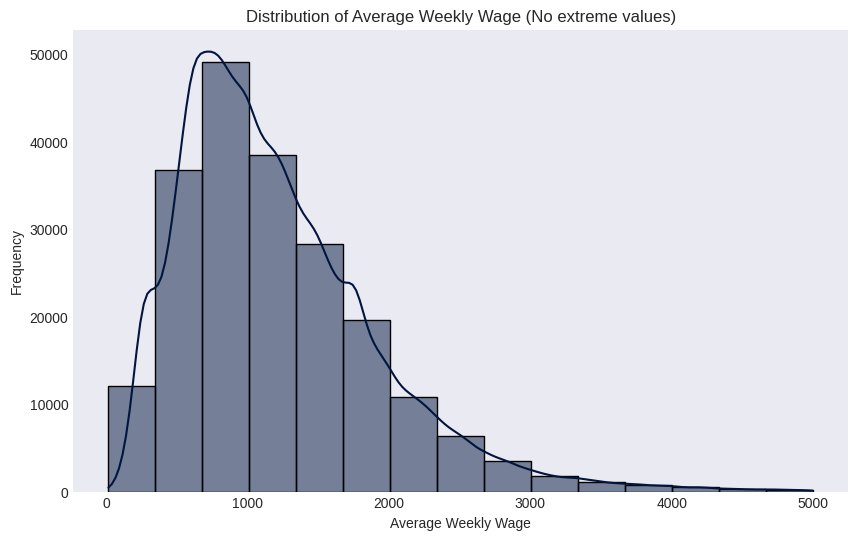

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(wage_, bins=15, color='#01153e', kde=True)
plt.title('Distribution of Average Weekly Wage (No extreme values)')
plt.xlabel('Average Weekly Wage')
plt.ylabel('Frequency')
plt.show()

Now it is clearer to see the underlying distribution, once we have removed the more extreme values. 

#### 3.1.2. Days Difference

In [8]:
days_ = df[df['Days Difference'] < 500]['Days Difference'].dropna().astype('float')

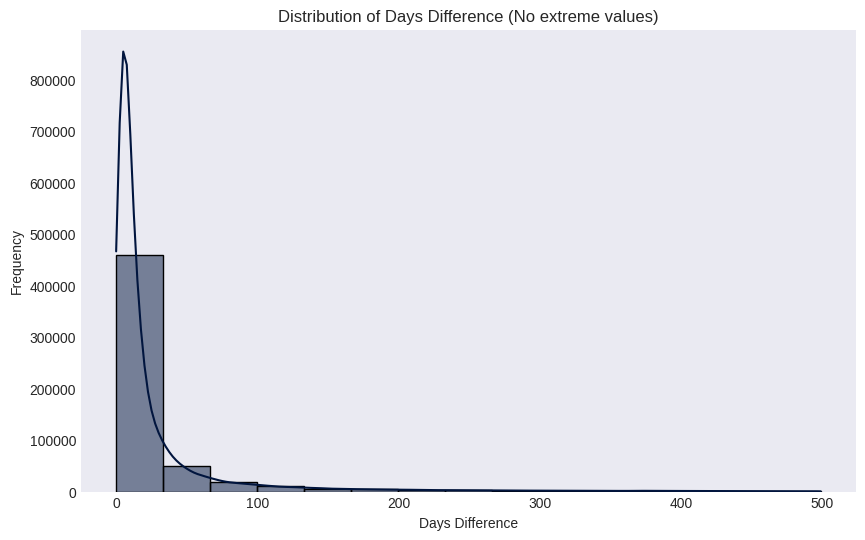

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(days_, bins=15, color='#01153e', kde=True)
plt.title('Distribution of Days Difference (No extreme values)')
plt.xlabel('Days Difference')
plt.ylabel('Frequency')
plt.show()

Most claims actually take up to around one month to get assembled, since the day of the accident.

### 3.2. Date Features

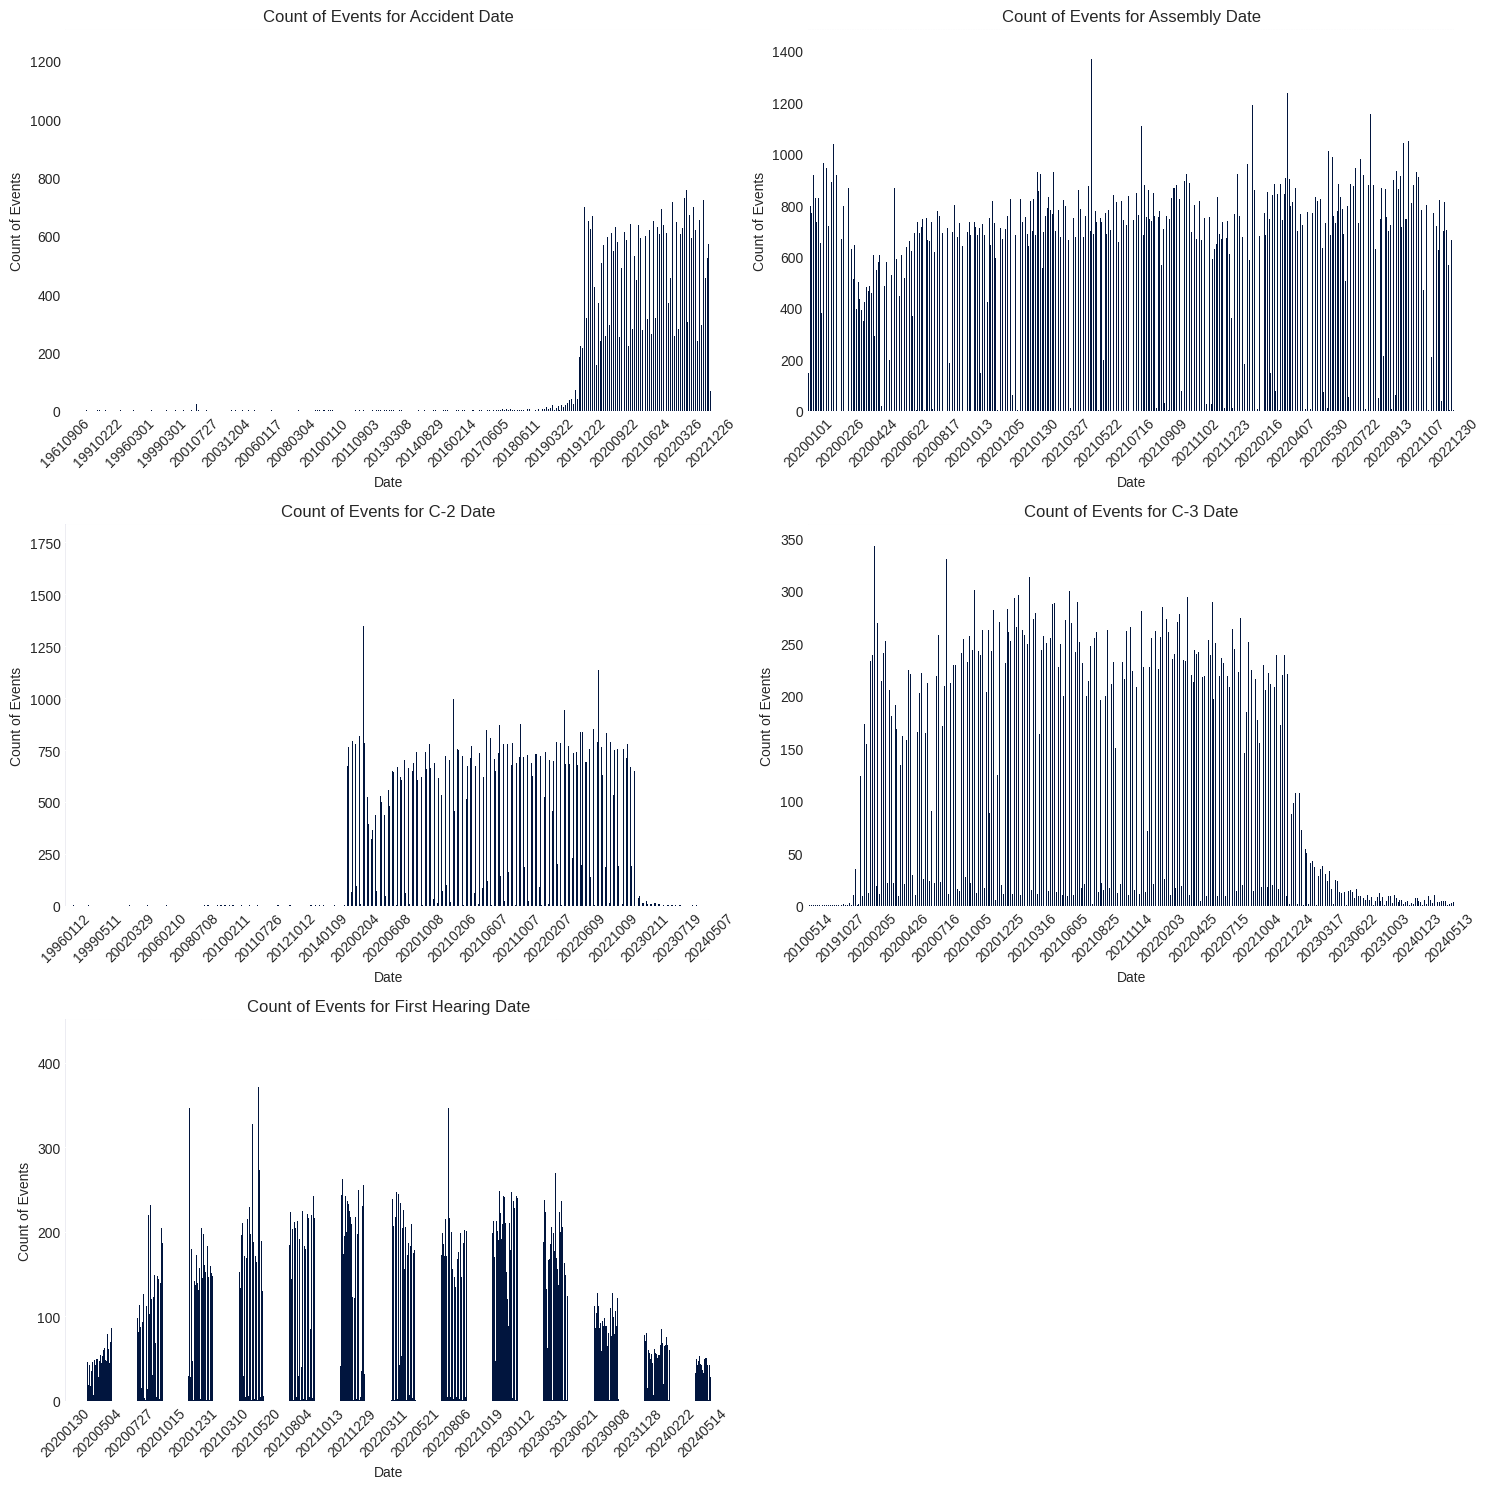

In [10]:
num_features = len(date_features)
num_columns = 2
num_rows = (num_features + num_columns - 1) // num_columns

# create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# iterate over each feature to plot counts
for ax, feature in zip(axes, date_features):
    # Count occurrences per date
    date_counts = df[feature].value_counts().sort_index()

    # Plotting the counts
    date_counts.plot(kind='bar', ax=ax, color='#01153e')
    ax.set_title(f'Count of Events for {feature}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count of Events')
    
    
    tick_indices = list(range(0, len(date_counts), max(1, len(date_counts) // 20)))
    tick_labels = [date_counts.index[i].strftime('%Y%m%d') if i in tick_indices else '' for i in range(len(date_counts))]
    ax.set_xticklabels(tick_labels, rotation=45)
    
    ax.grid()

# hide any empty subplots
for i in range(len(date_features), len(axes)):
    fig.delaxes(axes[i])

# adjust layout to prevent overlap
plt.tight_layout()

plt.show()

Looking at these plots, we observe the dataset contains accidents since 1961, with the first C-2 form being received in 1996 and C-3 forms in 2010 - this tells us there are some claims that are taking a long time to be assembled, since the dataset depicts claims that were assembled between 2020 and 2022.

### 3.3. Categorical Features

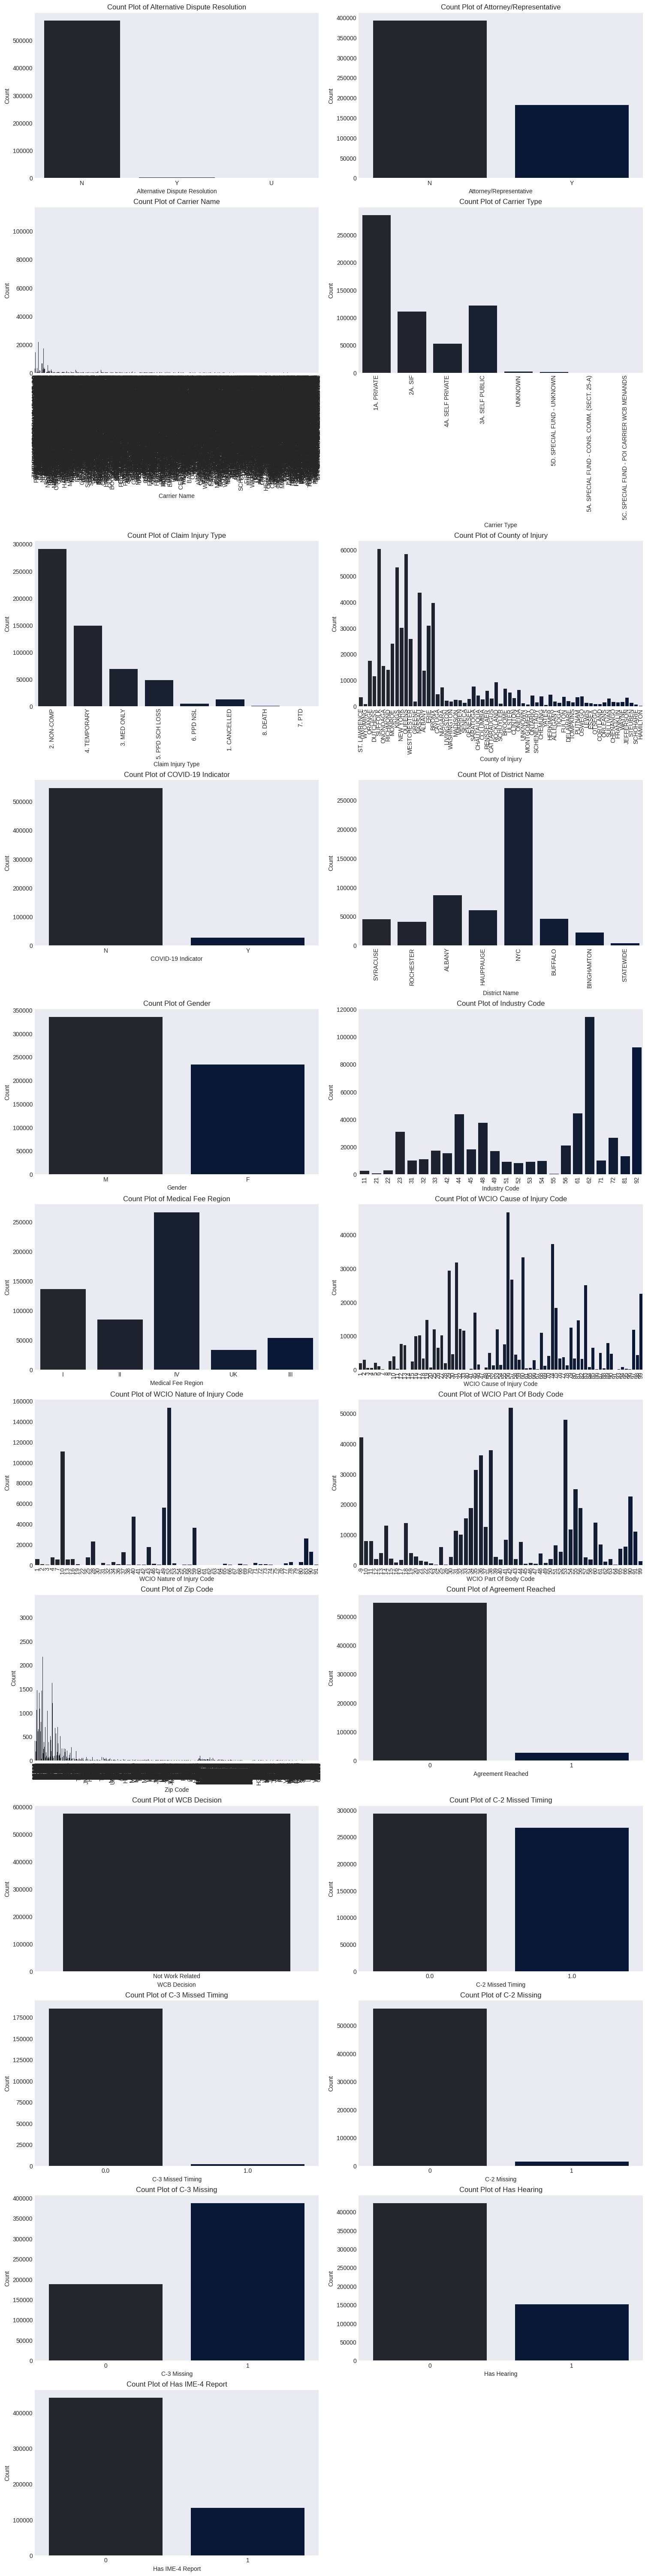

In [11]:
num_features = len(categorical_features)
num_columns = 2
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows), constrained_layout=True)

# Flatten the axes array for easier iteration if there's more than one row
axes = axes.flatten()

better_labels = ['Carrier Type', 'Claim Injury Type', 'County of Injury', 'District Name'
                 , 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code'
                 , 'WCIO Part Of Body Code', 'Zip Code', 'Carrier Name']

row_label_heights = []

# Loop through each categorical feature to plot count plots with Seaborn
for i, (ax, feature) in enumerate(zip(axes, categorical_features)):
    sns.countplot(data=df, x=feature, hue=feature, ax=ax, palette='dark:#01153e', legend=False)
    ax.set_title(f'Count Plot of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

    # Rotate labels if feature in better_labels
    if feature in better_labels:
        ax.tick_params(axis='x', rotation=90)

# Hide any unused subplots if the number of features is not even
for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.show()

According to the above countplots of the categorical features, there is some class imbalance in every feature, except for 'Gender' and the unary column 'WCB Decision'.

Features like 'Carrier Type', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code' and 'WCIO Part of Body Code' could benefit from some aggregations based on class similarity.

'County of Injury' already has an aggregation version of itself in 'District Name'; while 'Zip Code' could also be seen as a non-aggregated version of district name, we could also try another kind of aggregation and make this variable more interesting to use in the final model.

## 4. Boxplots

### 4.1. Numeric and Date Features

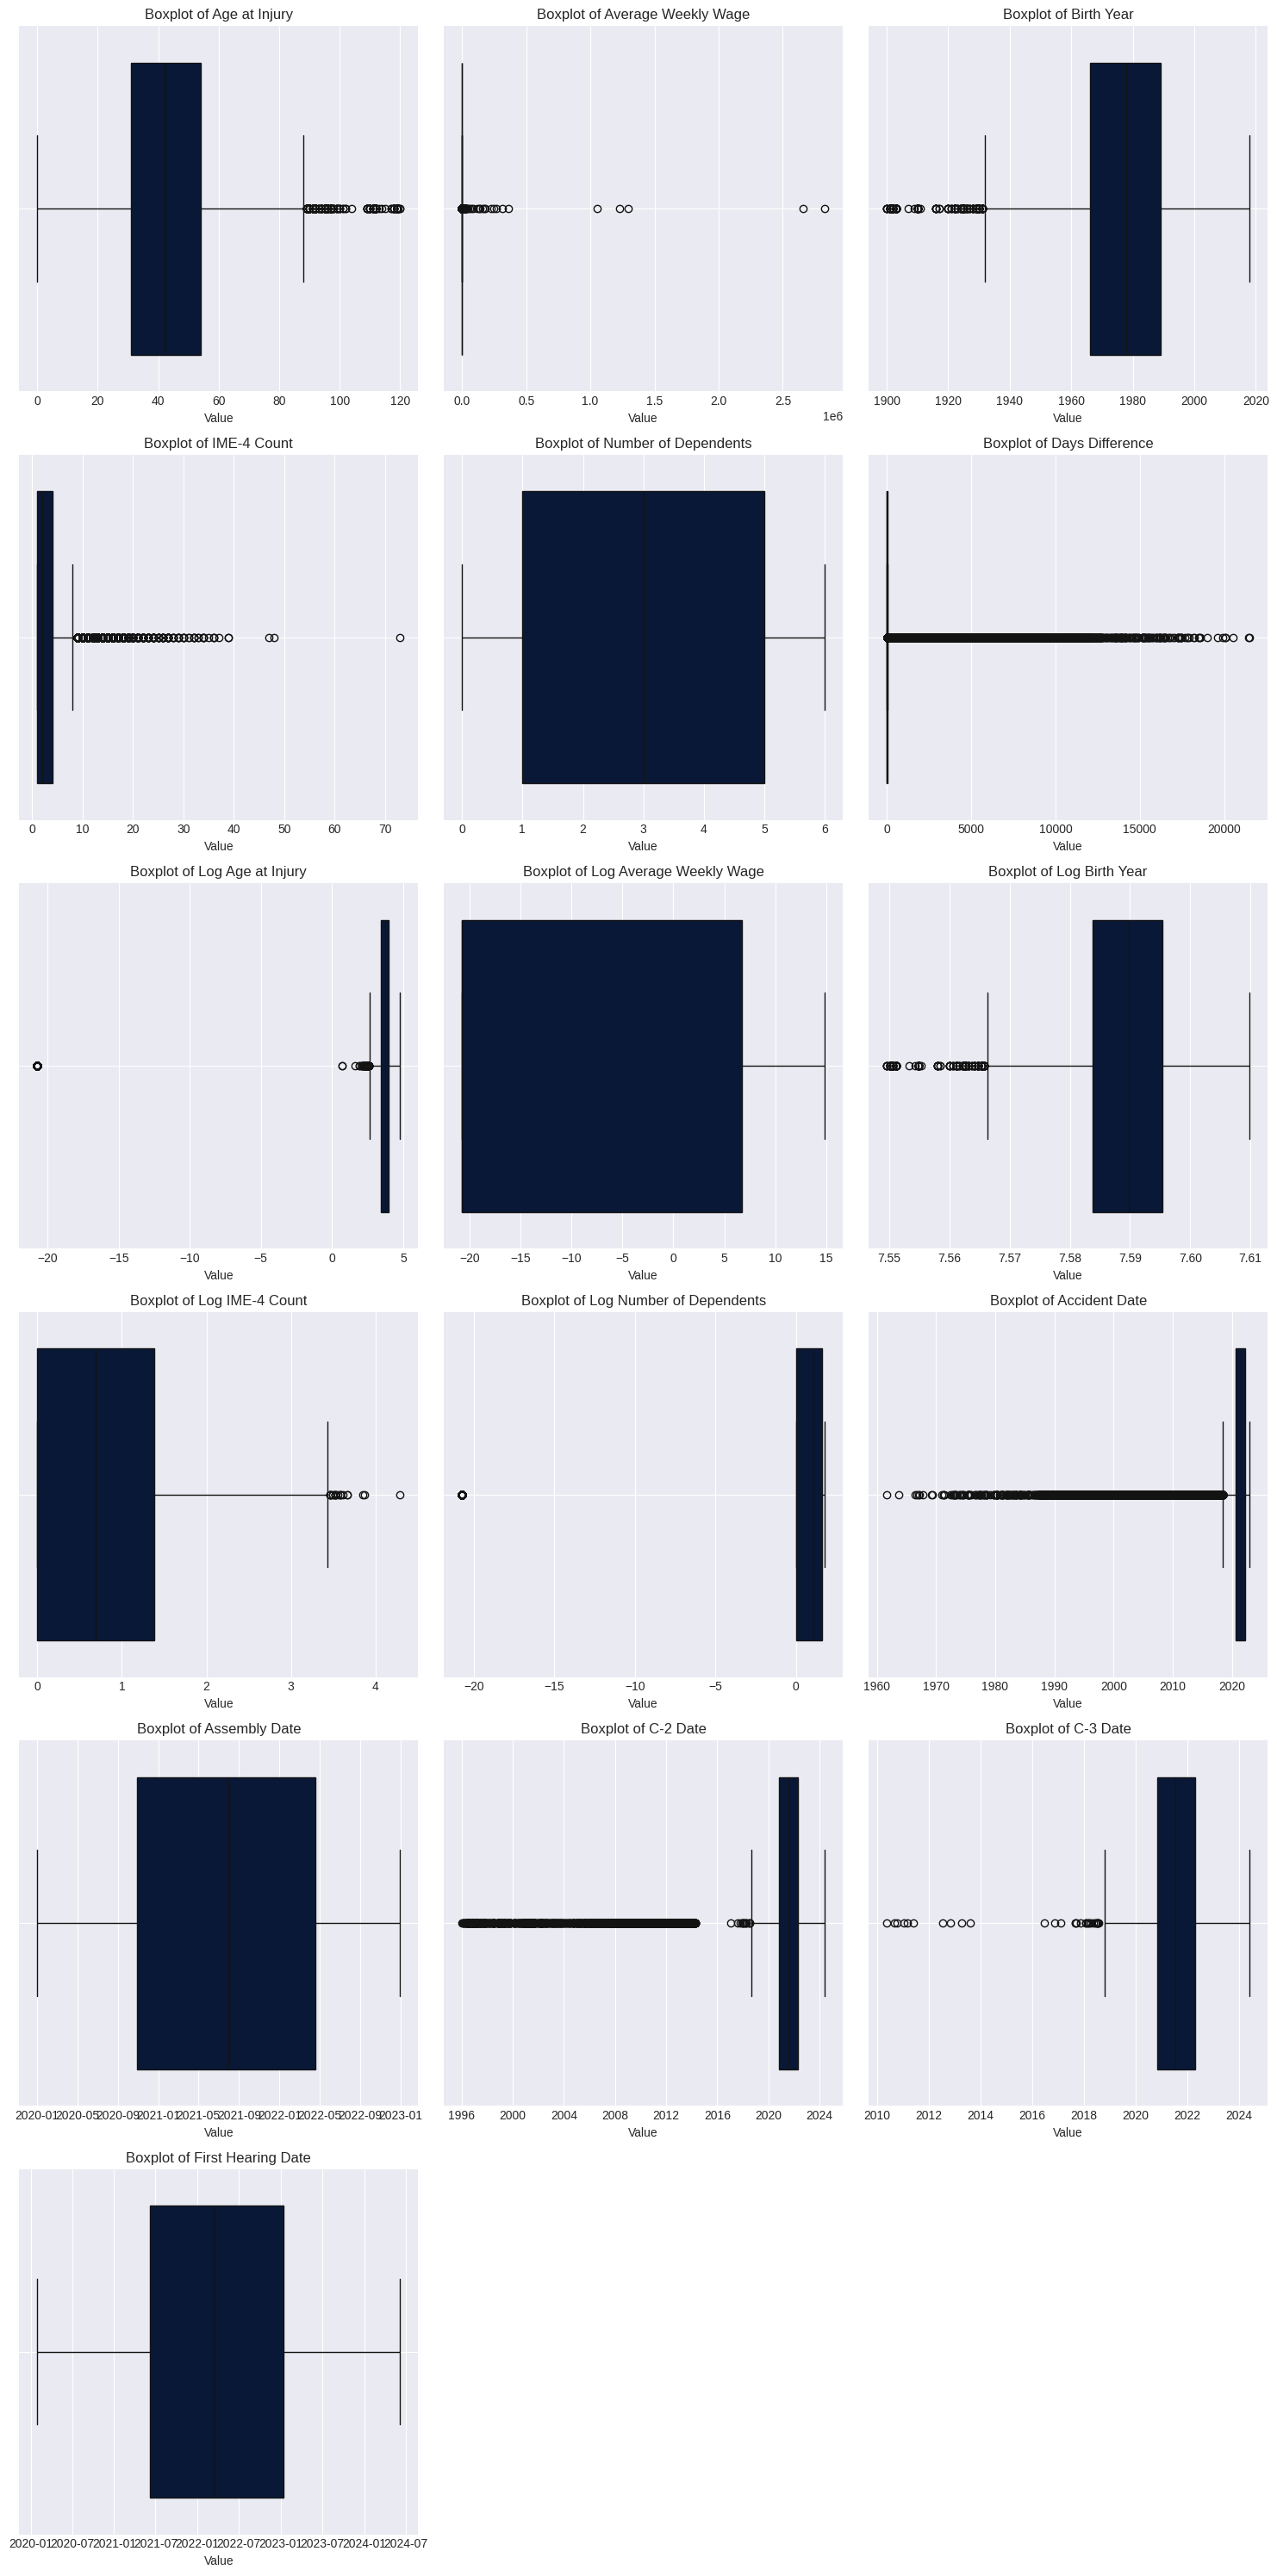

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

box_plot_features = [feature for feature in numeric_features + date_features if feature not in ['C-2 Missed Timing', 'C-3 Missed Timing', 'C-2 Missing', 'C-3 Missing', 'Has Hearing', 'Has IME-4 Report']]

num_features = len(box_plot_features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easier iteration if there's more than one row
axes = axes.flatten()

# Loop through each numeric feature to plot boxplots with Seaborn
for ax, feature in zip(axes, box_plot_features):
    sns.boxplot(x=df[feature], color='#01153e', ax=ax)  # Set color to match previous style
    ax.set_title(f'Boxplot of {feature}')
    ax.set_xlabel('Value')
    ax.grid(True)

# Hide any empty subplots if the number of features is not even
for i in range(len(box_plot_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


Looking at the boxplots, we can identify some unidimensional outliers for posteriority. Namely:
- **'Age at Injury':** any value on the right of the right wisker; since the average retirement age in the US is between 63 and 65, keeping only values up until the upper wisker is more than reasonable
- **'Average Weekly Wage'**: the values that are above the x-axis value of 0.5 do not make much sense as they are too distant from the majority of the data points
- **Birth Year**: values before 1916 are a bit far from the majority of the data points
- **IME-4 Count**: values after 40 can be considered extreme
- **Days Difference**: values bigger than 19000 are too far from the concentration of data points
- **Accident Date**: values before 1970 are too far from the majority of data points
- **C-2 Date**: values before 2016 could be considered outliers, but this would mean we would be left with almost no data points - these many values cannot be removed
- **C-3 Date**: values before 2016 are too far from the remaining data points

## 5. Correlation Matrices

### 5.1. Numeric features

First, let's encode the target variable to numeric so we can plot the correlation matrix.

In [13]:
# create a dataset with the numeric features and the target
df_corr_numeric = df[numeric_features + ['Claim Injury Type']].copy()

In [14]:
# keep only the number in the category values
df_corr_numeric['Claim Injury Type'] = df_corr_numeric['Claim Injury Type'].str[0]

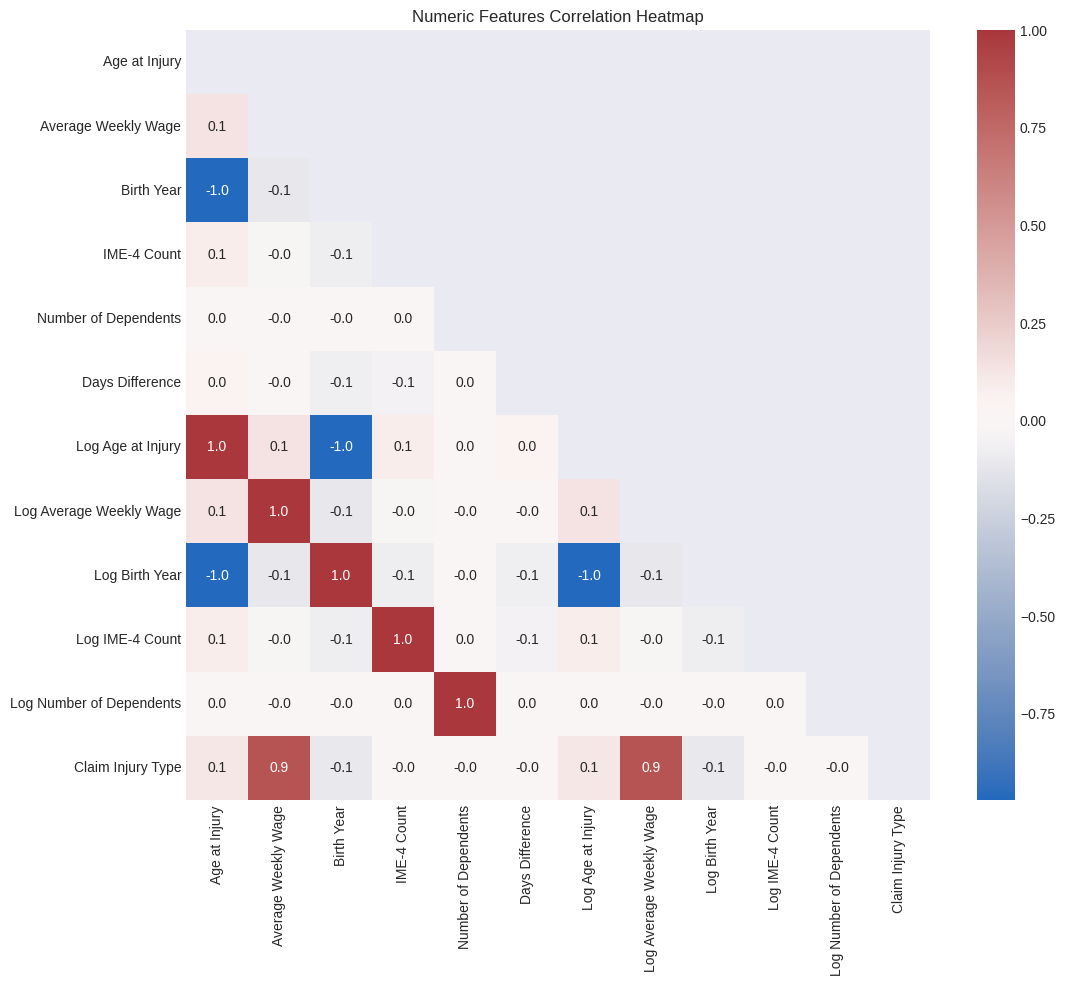

In [15]:
# compute the correlation matrix for the numeric columns
corr_matrix = df_corr_numeric.corr(method='spearman')

plt.figure(figsize=(12,10))

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# create the heatmap
sns.heatmap(data=corr_matrix, annot=True, cmap='vlag', fmt='.1f', mask=mask)

# Show the plot
plt.title('Numeric Features Correlation Heatmap')
plt.show()

Looking at this correlation matrix, we conclude:
- 'Birth Year' and 'Age at Injury' are inversely correlated
- 'Average Weekly Wage' is highly correlated with the target

### 5.2. Date features

Let us split the date columns into its components: Year, Month and Day

In [16]:
df_corr_dates = df[date_features].copy()

for col in date_features:
    df_corr_dates[f'{col} Year'] = df[col].dt.year
    df_corr_dates[f'{col} Month'] = df[col].dt.month
    df_corr_dates[f'{col} Day'] = df[col].dt.day

In [17]:
df_corr_dates['Claim Injury Type'] = df['Claim Injury Type'].str[0]

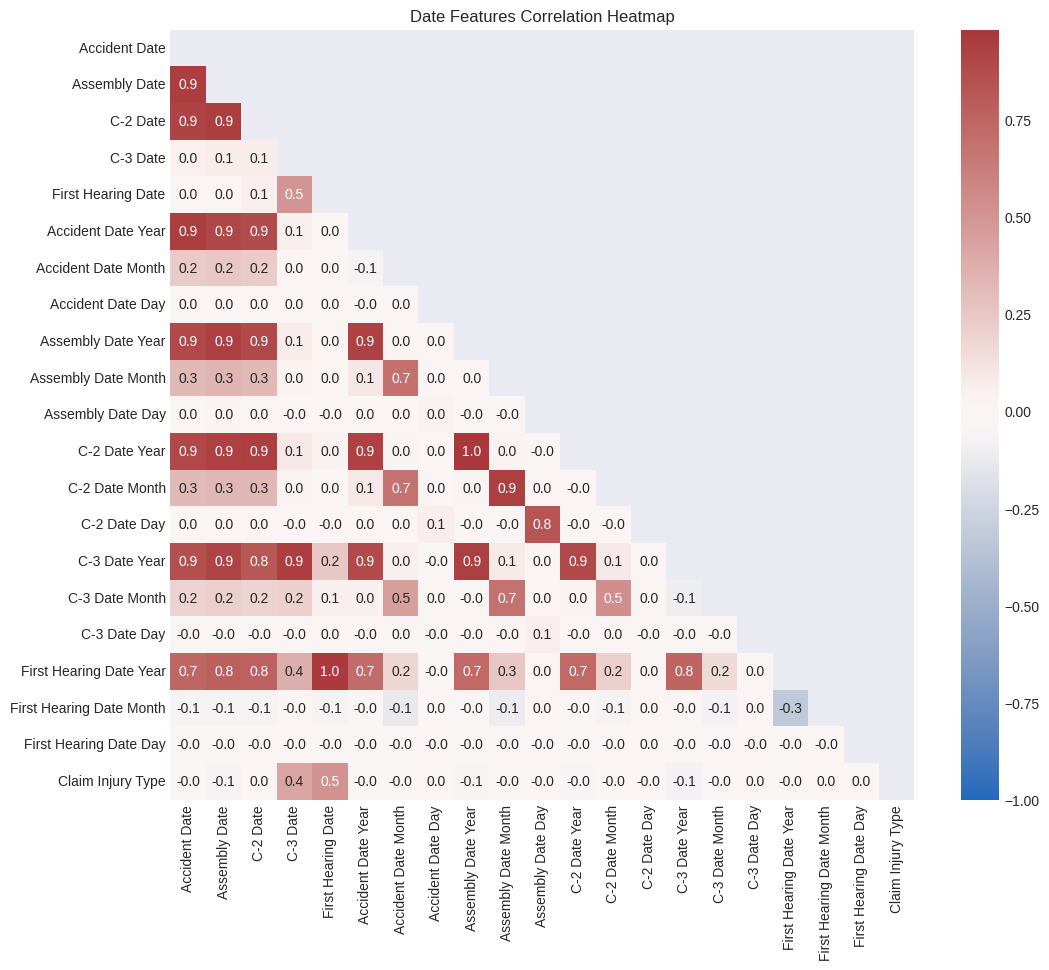

In [18]:
# compute the correlation matrix for the date columns
corr_matrix = df_corr_dates.corr(method='spearman')

plt.figure(figsize=(12,10))

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# create the heatmap
sns.heatmap(data=corr_matrix, annot=True, cmap='vlag', fmt='.1f', mask=mask, vmin=-1)

# Show the plot
plt.title('Date Features Correlation Heatmap')
plt.show()

Looking at this correlation matrix, we can see that splitting the dates into its calendar components did not yield great results for target correlation. However, 'First Hearing Date' and 'C-3 Date' have a moderate correlation with the target. <br>
In addition, 'Accident Date', 'Accident Date' and 'C-2 Date' are highly correlated among themselves and with 'C-3 Date Year' and 'First Hearing Date Year'.

### 5.3. Categorical features

In [19]:
df_corr_cat = df[categorical_features].copy()

In [20]:
df_corr_cat.drop(columns=['Claim Injury Type'], inplace=True)
df_corr_cat['Claim Injury Type'] = df['Claim Injury Type'].str[0]

In [21]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = sc.stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)

    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [22]:
for var in df_corr_cat.iloc[:, :-1]:
    TestIndependence(df_corr_cat[var],df_corr_cat.iloc[:, -1], var)

Alternative Dispute Resolution is IMPORTANT for Prediction
Attorney/Representative is IMPORTANT for Prediction
Carrier Name is IMPORTANT for Prediction
Carrier Type is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
COVID-19 Indicator is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Industry Code is IMPORTANT for Prediction
Medical Fee Region is IMPORTANT for Prediction
WCIO Cause of Injury Code is IMPORTANT for Prediction
WCIO Nature of Injury Code is IMPORTANT for Prediction
WCIO Part Of Body Code is IMPORTANT for Prediction
Zip Code is IMPORTANT for Prediction
Agreement Reached is IMPORTANT for Prediction
WCB Decision is NOT an important predictor. (Discard WCB Decision from model)
C-2 Missed Timing is IMPORTANT for Prediction
C-3 Missed Timing is IMPORTANT for Prediction
C-2 Missing is IMPORTANT for Prediction
C-3 Missing is IMPORTANT for Prediction
Has Hearing is IMPORTANT for Prediction
Has IME-4 Report

/tmp/ipykernel_35501/1167056094.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_35501/1167056094.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_35501/1167056094.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_35501/1167056094.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_35501/1167056094.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_35501/1167056094.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
/tmp/ipykernel_35501/1167056094.py:10: RuntimeWarning: inv

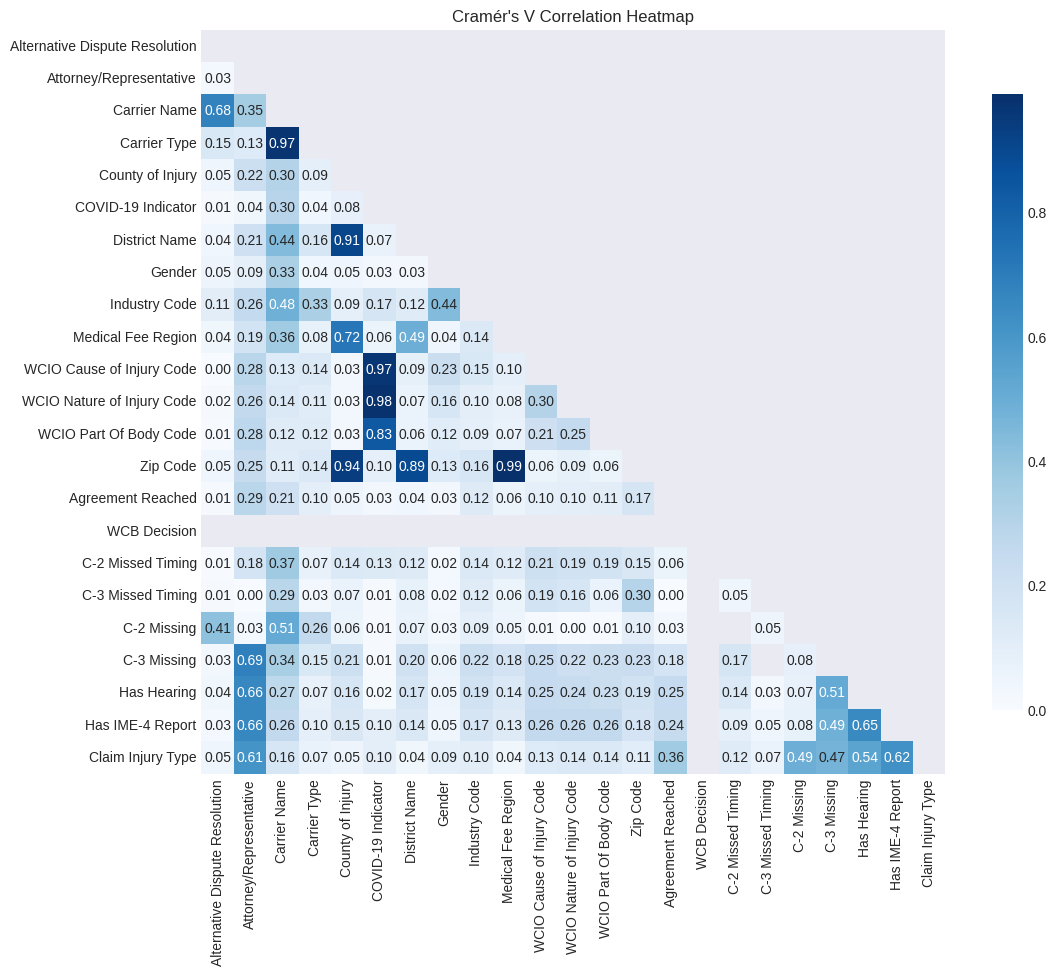

In [23]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = sc.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - (r - 1) ** 2 / (n - 1)
    kcorr = k - (k - 1) ** 2 / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# get categorical features
features = df_corr_cat.columns

# create a correlation matrix
cramers_v_matrix = pd.DataFrame(index=features, columns=features)

for col1 in features:
    for col2 in features:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# convert to numeric
cramers_v_matrix = cramers_v_matrix.astype(float)

# create a mask for the upper triangle
mask = np.triu(np.ones_like(cramers_v_matrix, dtype=bool))

# plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, annot=True, cmap='Blues', square=True, cbar_kws={'shrink': .8}, fmt=".2f", mask=mask)
plt.title("Cramér's V Correlation Heatmap")
plt.show()

By analysing the heatmap above, we can see that 'Attoney/Representative' has a high degree of correlation with the target and, even though with a much lower value, 'Agreement Reached' is also somewhat correlated with the target.</br></br>
Some more correlations:
- 'Carrier Name' and 'Alternative Dispute Resolution' are also correlated
- 'Carrier Type' and 'Carrier Name' are almost perfectly correlated.
- 'District Name' and 'Zip Code' are highly correlated with 'County of Injury'
- 'Medical Fee Region' has a high degree of correlation with 'County of Injury'
- The WCIO codes and descriptions are highly correlated with 'COVID-19 Indicator'
- 'District Name' is highly correlated with 'Zip Code' and has some degree of correlation with 'Medical Fee Region'
- 'Medical Fee Region' and 'Zip Code' are almost perfectly correlated
- 'Alternative Dispute Resolution' is moderately correlated with 'C-2 Missing'
- 'C-3 Missing', 'Has Hearing' and 'Has IME-4 Report' are correlated among themselves as well as with 'Attorney/Representative' and with the target
- 'C-2 Missing' is corellated with the target

## 6. Multivariate analysis

### 6.1. WCIO Nature of Injury Description and Industry Code Description

In [24]:
# remove missing values from 'WCIO Nature of Injury Description'
filtered_data = df.dropna(subset=['WCIO Nature of Injury Description'])

# select the top 5 injuries
common_injuries = filtered_data['WCIO Nature of Injury Description'].value_counts().head(5)

In [25]:
filtered_data = filtered_data[filtered_data['WCIO Nature of Injury Description'].isin(common_injuries.index)]

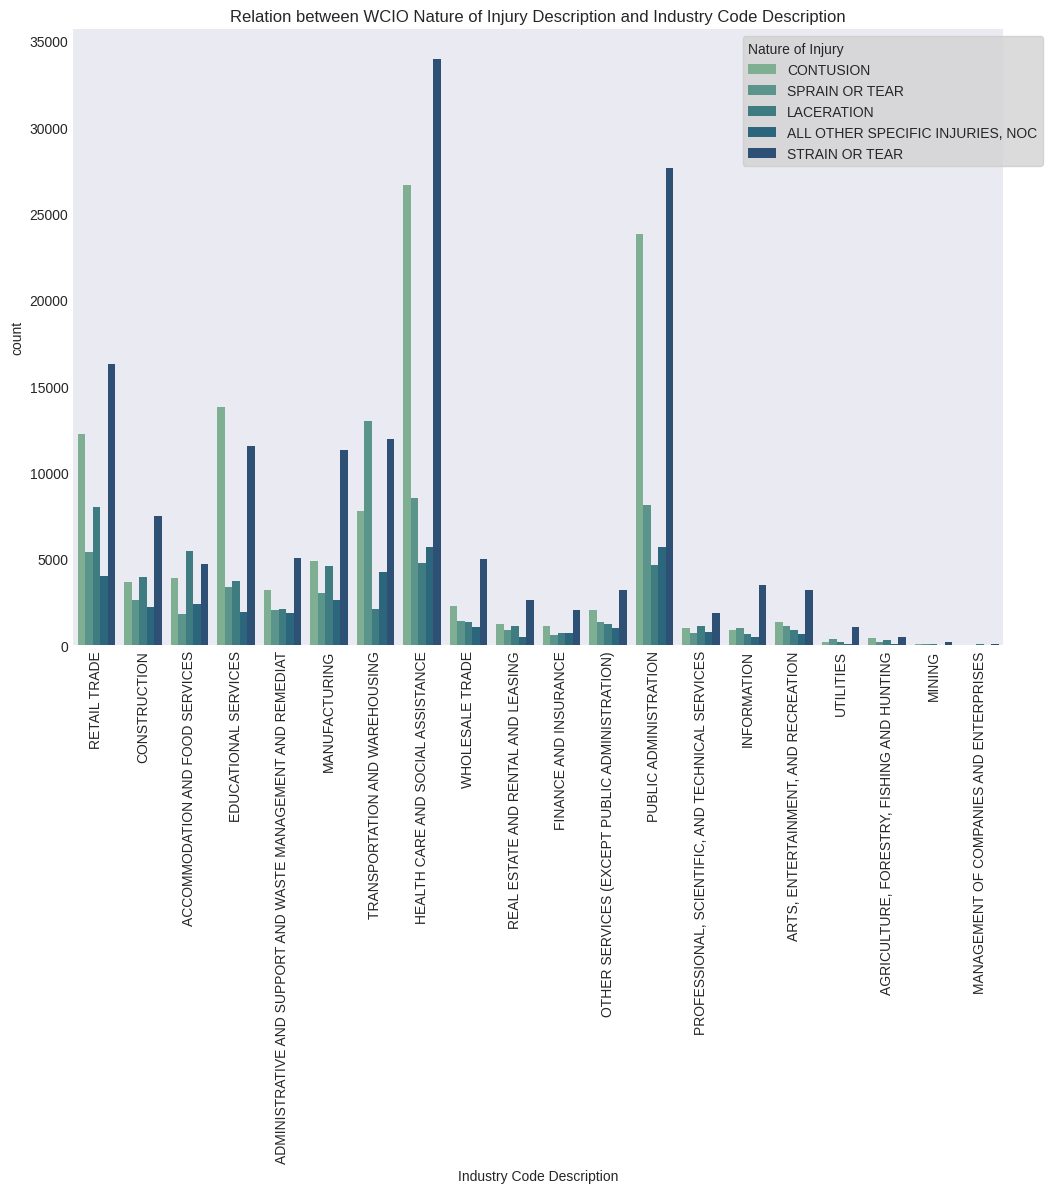

In [26]:
# countplot for the relationship between Injuries and Industry
plt.figure(figsize=(12, 8))
sns.countplot(x='Industry Code Description', hue='WCIO Nature of Injury Description', data=filtered_data, palette="crest")
plt.title('Relation between WCIO Nature of Injury Description and Industry Code Description')
plt.xticks(rotation=90)

plt.legend(title='Nature of Injury', bbox_to_anchor=(1.05, 1), loc='upper right'
           , frameon=True, facecolor='lightgray', alignment='left')

plt.show()

This plots shows us the disparity of the types and amount of injuries across the different industries. On all, STRAIN OR TEAR and CONTUSION are the most occurring injuries and there are two industries were the amount of injuries is way larger than in the others, HEALTH CARE AND SOCIAL ASSISTANCE and PUBLIC ADMINISTRATION.

### 6.2. Claim Injury Type and Attorney/Representative

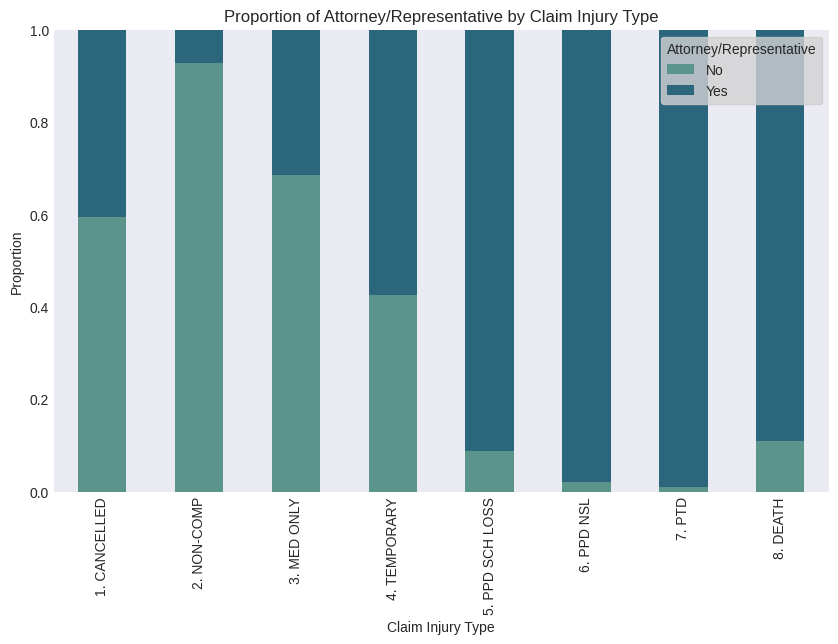

In [27]:
counts = df.groupby(['Claim Injury Type', 'Attorney/Representative']).size().unstack()
counts = counts.dropna(axis=1, how='any')

# convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get proportions

# plotting
proportions.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#5a948a', '#2b667c'])

plt.title('Proportion of Attorney/Representative by Claim Injury Type')
plt.xlabel('Claim Injury Type')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='Attorney/Representative', labels=['No', 'Yes'], loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

This graphs shows us the involvement of attorneys or representatives on claims, by type.
The more severe Claim Injury Types (5 and onwards) are almost exclusively associated with claims from individuals who had legal representation.
On the other hand, it seems that the lack of legal representation leads either to a cancelled claim, a non-compensated one, or a very low severity outcome.

### 6.3. Average Weekly Wage by Attorney/Representative

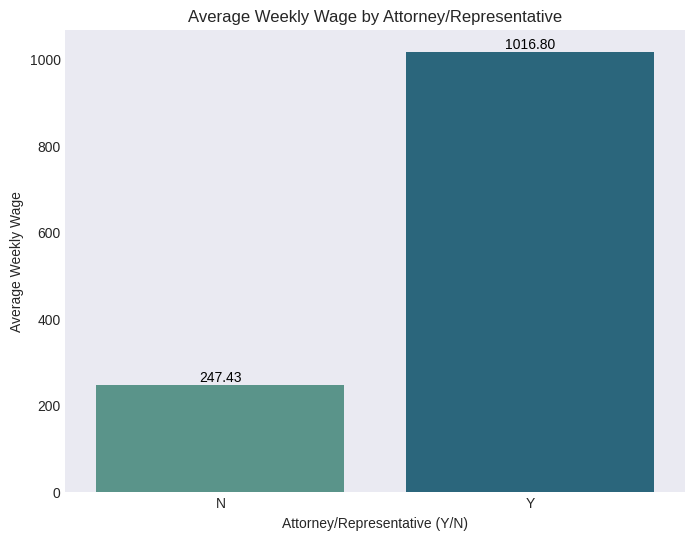

In [28]:
# calculate the mean 'Average Weekly Wage' for each 'Attorney/Representative' category
mean_wage_by_lawyer = df.groupby('Attorney/Representative')['Average Weekly Wage'].mean().reset_index()

palette = sns.color_palette("crest", n_colors=2)

# create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Attorney/Representative', y='Average Weekly Wage', data=mean_wage_by_lawyer
                       , hue='Attorney/Representative', palette=palette, legend=False)

plt.title('Average Weekly Wage by Attorney/Representative')
plt.xlabel('Attorney/Representative (Y/N)')
plt.ylabel('Average Weekly Wage')

# annotate the bar plot with the actual mean values
for index, row in mean_wage_by_lawyer.iterrows():
    bar_plot.text(index, row['Average Weekly Wage'], f"{row['Average Weekly Wage']:.2f}", 
                  color='black', ha="center", va="bottom")

plt.show()

This barplot shows us the average value of Average Weekly Wage for the people that had or not an attorney/representative in their claims. The difference in wages is astronomic and rather interesting to know, since people with legal representation earn roughly four times more than those who do not.

### 6.4. Carrier Type and Claim Injury Type

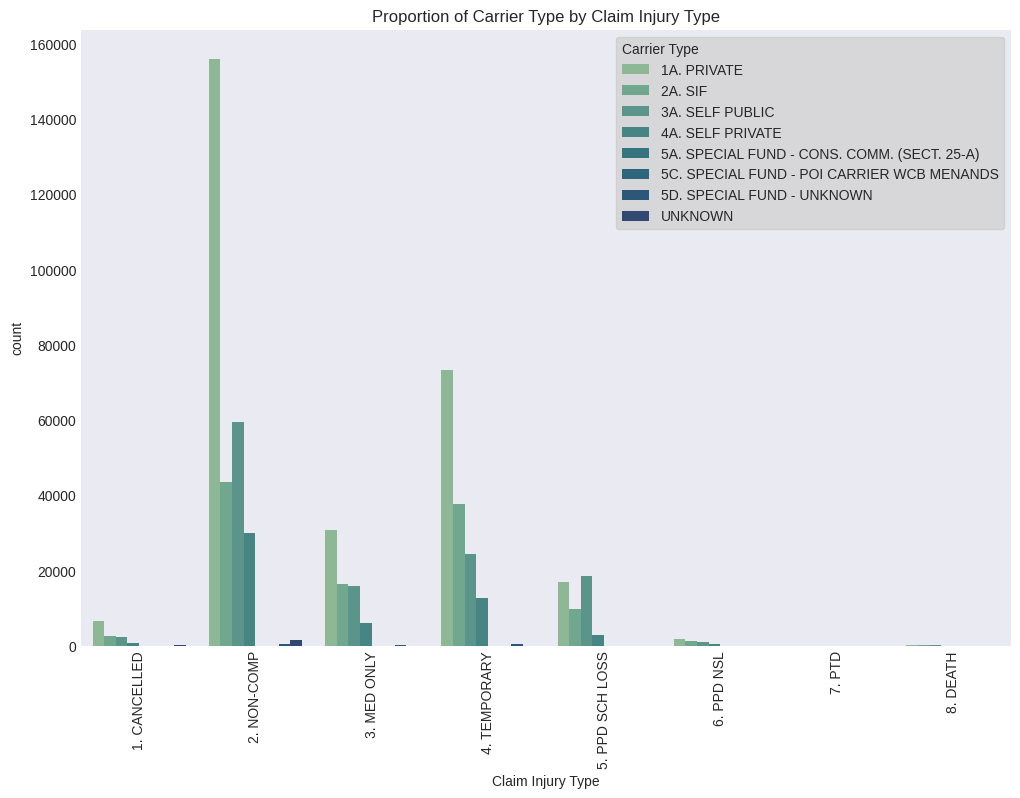

In [29]:
# countplot for the relationship between Injuries and Industry
plt.figure(figsize=(12, 8))
sns.countplot(x='Claim Injury Type', hue='Carrier Type', data=df, palette="crest", hue_order=sorted(df['Carrier Type'].unique()), order=sorted(df['Claim Injury Type'].unique()))
plt.title('Proportion of Carrier Type by Claim Injury Type')
plt.xlabel('Claim Injury Type')
plt.xticks(rotation=90) 

plt.legend(title='Carrier Type', loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.show()

This countplot shows us the number of calims by Claim Injury Type and Carrier Type. We verify that most claims that were classified as Non-compensated had a Private Carrier; in fact, throughout almost every Claim Injury Type, most claims had a Private carrier, i.e. most employers contract a Private Insurer.

### 6.5. Carrier Type and Attorney/Representative

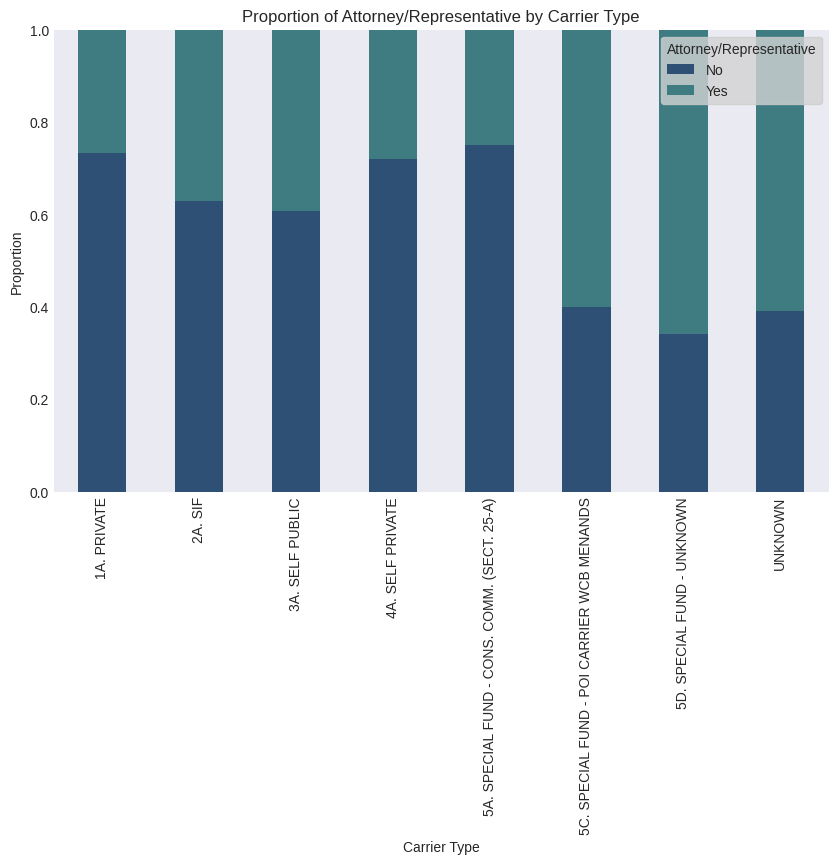

In [30]:
counts = df.groupby(['Carrier Type', 'Attorney/Representative']).size().unstack()
counts = counts.dropna()

# convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get proportions

# plotting
proportions.plot(kind='bar', stacked=True, color=['#2f5075', '#3e7c82'], figsize=(10, 6))

plt.title('Proportion of Attorney/Representative by Carrier Type')
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='Attorney/Representative', labels=['No', 'Yes'], loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

According to this plot, which shows the proportion of people that had legal representation across the different Carrier Types, most people did not have any kind of legal representation. However, as wee saw in Section 5.2, the majority of people that received any kind of compensation had an attorney/representative.<br>
This clearly shows that having legal representation deems more meaningful for the claim outcome than the insurance provider.

### 6.6. Claim Injury Type and COVID-19 Indicator

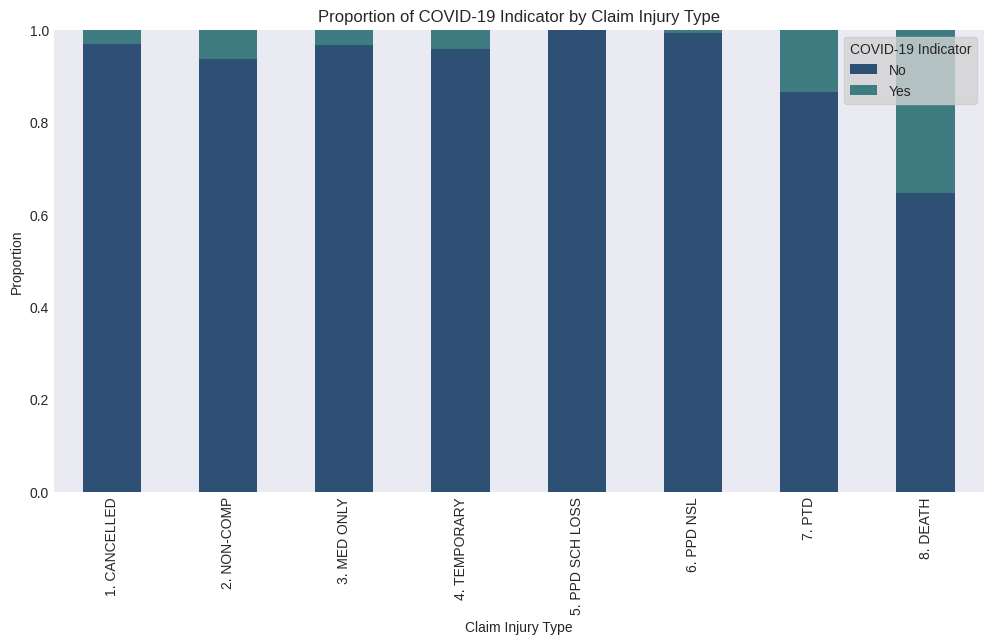

In [31]:
counts = df.groupby(['Claim Injury Type', 'COVID-19 Indicator']).size().unstack()
counts = counts.dropna(axis=1, how='any')

# convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  

# plotting
proportions.plot(kind='bar', stacked=True, color=['#2f5075', '#3e7c82'], figsize=(12, 6))

plt.title('Proportion of COVID-19 Indicator by Claim Injury Type')
plt.xlabel('Claim Injury Type')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='COVID-19 Indicator', labels=['No', 'Yes'], loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

We can see that we do not have a lot of claims related with Covid-19; however, around 35% of Death-classified claims were related with Covid-19.

### 6.7. Average Weekly Wage and Age at Injury

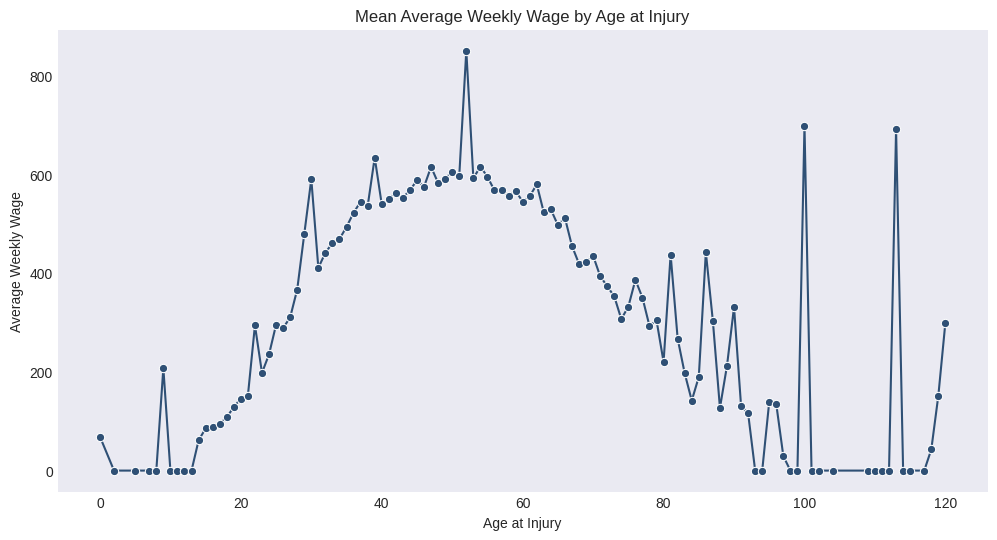

In [32]:
# create a line plot
mean_wage_by_age = df.groupby('Age at Injury')['Average Weekly Wage'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Age at Injury', y='Average Weekly Wage', data=mean_wage_by_age, marker='o', color='#2f5075')

plt.title('Mean Average Weekly Wage by Age at Injury')
plt.xlabel('Age at Injury')
plt.ylabel('Average Weekly Wage')

plt.show()

In this graph we see the relationship between age and wage; after a quick internet query, we verify that this plot represents the real trend of this relationship. This proves our data is rather clean and does not have many outliers in this regard.

### 6.8. Days Difference and Age at Injury

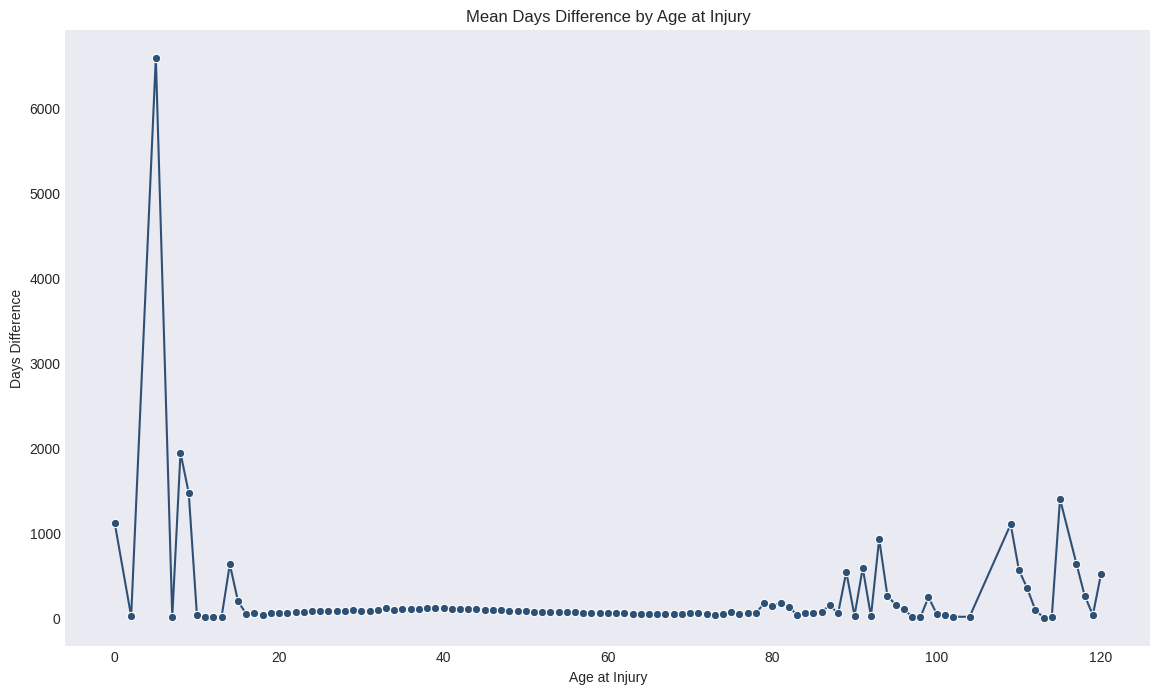

In [33]:
# create a line plot
mean_daysdif_by_age = df.groupby('Age at Injury')['Days Difference'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Age at Injury', y='Days Difference', data=mean_daysdif_by_age, marker='o', color='#2f5075')

plt.title('Mean Days Difference by Age at Injury')
plt.xlabel('Age at Injury')
plt.ylabel('Days Difference')

plt.show()

There is a bit more efficiency in treating the claims of people between 17 and 85 years of age - this shows there is a bit more delay in treating the claims of older people; however, there is a possibility that these people are actually outliers, since, as we mentioned before, the average retirement age in the US is between 63 and 65 years-old.

### 6.9.Days Difference and District Name

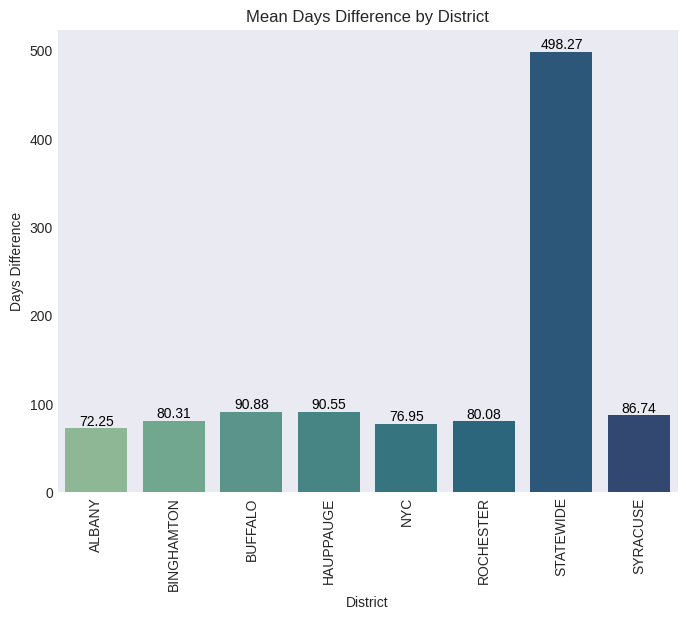

In [34]:
mean_daysdif_by_district = df.groupby('District Name')['Days Difference'].mean().reset_index()

# create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='District Name', y='Days Difference', data=mean_daysdif_by_district, palette="crest", hue='District Name', legend=False)

plt.title('Mean Days Difference by District')
plt.xlabel('District')
plt.ylabel('Days Difference')
plt.xticks(rotation=90)

# annotate the bar plot with the mean values
for index, row in mean_daysdif_by_district.iterrows():
    bar_plot.text(index, row['Days Difference'], f"{row['Days Difference']:.2f}", 
                  color='black', ha="center", va="bottom")

plt.show()

On average, a claim takes around three months to be assembled since the accident date. Eventhough this holds true, we see a massive difference in the cases of the district Statewide which on average take one and a half years to get assembled.

### 6.10. Atorney/Representative and District Name

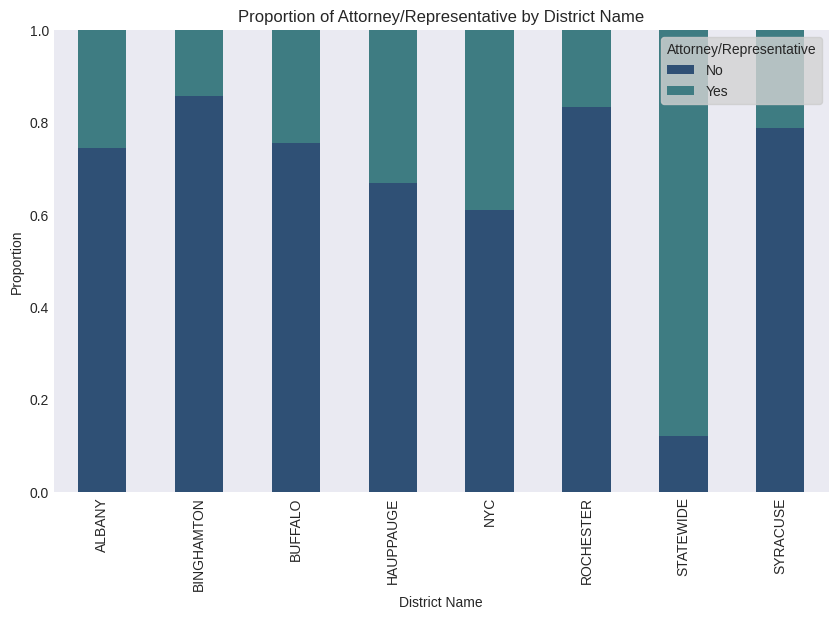

In [35]:
counts = df.groupby(['District Name', 'Attorney/Representative']).size().unstack()
counts = counts.dropna(axis=1, how='any')

# convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get proportions

# plotting
proportions.plot(kind='bar', stacked=True, color=['#2f5075', '#3e7c82'], figsize=(10, 6))

plt.title('Proportion of Attorney/Representative by District Name')
plt.xlabel('District Name')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='Attorney/Representative', labels=['No', 'Yes'], loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

This graph shows the proportion of claims per district that had legal representation. An interesting observation is that the Statewide district has 85% of its claims with legal representation. Combining this information with that from the previous plot, one could conclude that a slower claim assembly process is related to the acquisition of an attorney/representative.

### 6.11. Mean Days Difference by Attorney/Representative

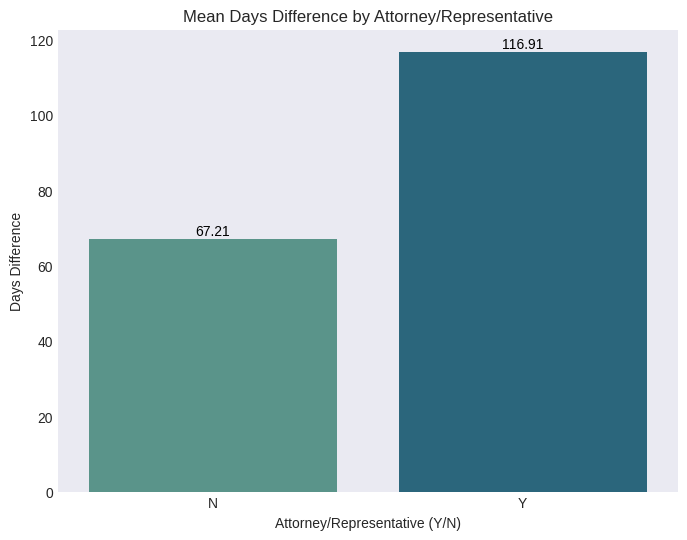

In [36]:
mean_daysdif_by_lawyer = df.groupby('Attorney/Representative')['Days Difference'].mean().reset_index()

# create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Attorney/Representative', y='Days Difference', data=mean_daysdif_by_lawyer, palette='crest', hue='Attorney/Representative', legend=False)

plt.title('Mean Days Difference by Attorney/Representative')
plt.xlabel('Attorney/Representative (Y/N)')
plt.ylabel('Days Difference')

# annotate the bar plot with the mean values
for index, row in mean_daysdif_by_lawyer.iterrows():
    bar_plot.text(index, row['Days Difference'], f"{row['Days Difference']:.2f}", 
                  color='black', ha="center", va="bottom")

plt.show()

We can see that the claim assembly process takes longer under legal representation, which can indicate the time needed to acquire an attorney.

### 6.12. Age at Injury and IME-4 Count

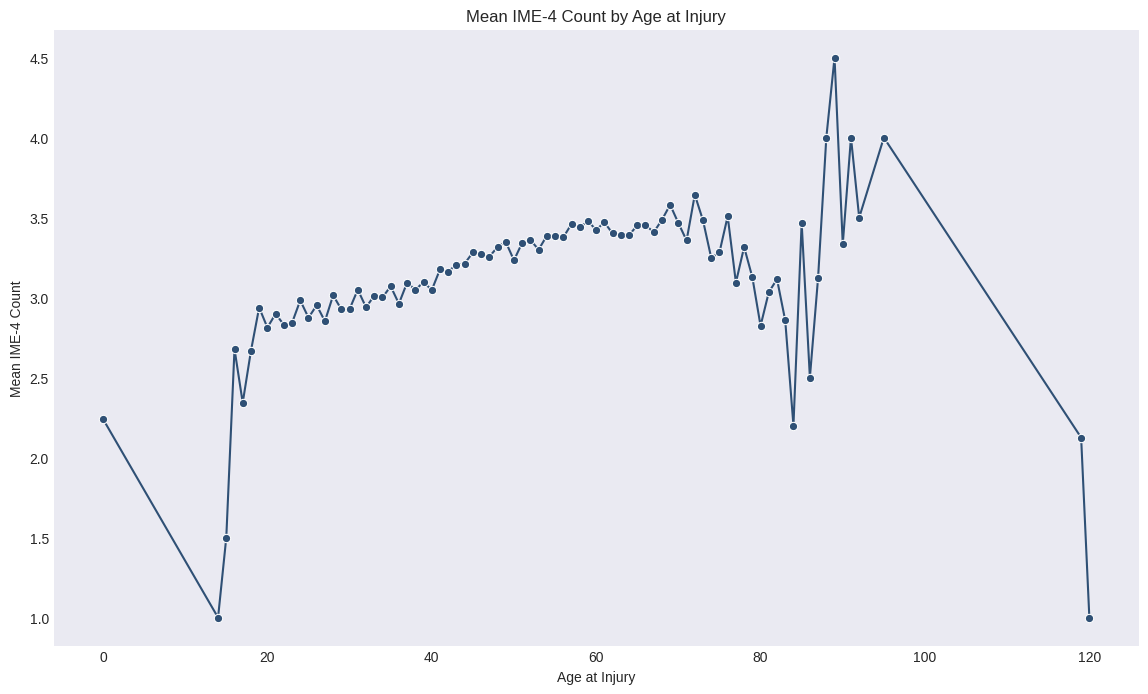

In [37]:
# create a line plot
mean_ime_by_age = df.groupby('Age at Injury')['IME-4 Count'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Age at Injury', y='IME-4 Count', data=mean_ime_by_age, marker='o', color='#2f5075')

plt.title('Mean IME-4 Count by Age at Injury')
plt.xlabel('Age at Injury')
plt.ylabel('Mean IME-4 Count')

plt.show()

This plot tells us that, with age, claims require, on average, a larger amount of independent examiners' reports.

### 6.13. Alternative Dispute Resolution and Claim Injury Type

In [38]:
df.groupby(['Alternative Dispute Resolution', 'Claim Injury Type']).size().unstack(fill_value=0)

Claim Injury Type,1. CANCELLED,2. NON-COMP,3. MED ONLY,4. TEMPORARY,5. PPD SCH LOSS,6. PPD NSL,7. PTD,8. DEATH
Alternative Dispute Resolution,,,,,,,,
N,12457,288483,68906,148504,48280,4211,97,470
U,0,5,0,0,0,0,0,0
Y,19,2590,0,0,0,0,0,0


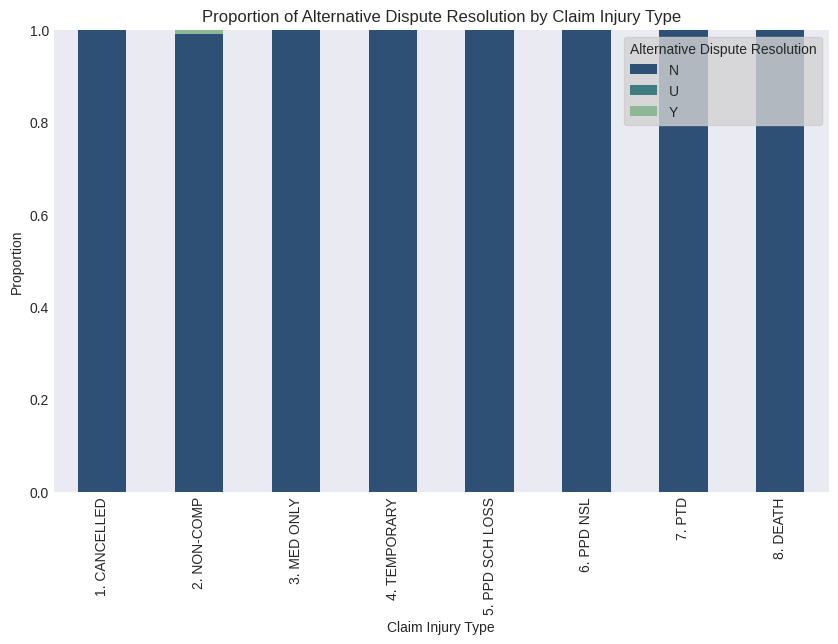

In [39]:
counts = df.groupby(['Claim Injury Type', 'Alternative Dispute Resolution']).size().unstack(fill_value=0)

# convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)  # Normalize to get proportions

# plotting
proportions.plot(kind='bar', stacked=True, color=['#2f5075', '#3e7c82', '#8db795'], figsize=(10, 6))

plt.title('Proportion of Alternative Dispute Resolution by Claim Injury Type')
plt.xlabel('Claim Injury Type')
plt.ylabel('Proportion')
plt.xticks(rotation=90) 

plt.legend(title='Alternative Dispute Resolution', loc='upper right', frameon=True, facecolor='lightgray', alignment='left')

plt.ylim(0, 1)  # Set y-axis limits for percentage representation
plt.show()

We can see that most claims in this dataset were not granted an alternative dispute resolution; moreover, the ones that were, were classified as Non-compensated or Cancelled.

## 7. Export

As we prepare to start cleaning and pre-processing our data, we will export the data without some of the features: the descriptive, unary and empty ones.

In [40]:
columns_to_drop = [
    'Industry Code Description'
    , 'OIICS Nature of Injury Description'
    , 'WCIO Cause of Injury Description'
    , 'WCIO Nature of Injury Description'
    , 'WCIO Part Of Body Description'
    # these next two columns are not in the test dataset
    , 'WCB Decision'
    # this one we will not remove, since we will attempt to predict it on the Open-Ended Section
    # , 'Agreement Reached'
]

In [41]:
df.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop[:-1], inplace=True)

In [42]:
df_dict = {
    'train': df
    ,'test': df_test
}

for name, dataframe in df_dict.items():
    # save dataframe datatypes to dictionary
    dtypes_dict = dataframe.dtypes.apply(lambda x: str(x)).to_dict()

    # save dataframe datatypes to json
    with open(f'../Data/{name}_dtypes_visual_exploration.json', 'w') as f:
        json.dump(dtypes_dict, f)

In [43]:
df.to_csv('../Data/train_data_visual_exploration.csv', index=True)
df_test.to_csv('../Data/test_data_visual_exploration.csv', index=True)